In [1]:
%run /home/analysis_user/New_trap_code/Tools/basic_packages.py
from matplotlib.ticker import MaxNLocator


plt.rcParams["figure.figsize"] = (16,12)
plt.rcParams["font.size"] = 24
plt.rcParams['xtick.labelsize'] = "small"
plt.rcParams['ytick.labelsize'] = 36

In [2]:
# this functions fits a sine to the discharge data and extacts the response around the drive frequency

ll = likelihood_analyser.LikelihoodAnalyser()
def get_scale(i,phase="sin",fsamp=5000,drive_freq=71,decimate=10,bandwidth=2):
    calibrationFile = step_cal_files[i]       
    calibFreqs = np.fft.rfftfreq(len(calibrationFile.electrode_data[0]), d=1./5000)
    fft_angles = np.angle(np.fft.rfft(calibrationFile.electrode_data[0]))
    if(phase=="cos"):
        phaseResponse = (fft_angles[calibFreqs==drive_freq])%(2*np.pi)
    elif(phase=="sin"):
        phaseResponse = (fft_angles[calibFreqs==drive_freq]+np.pi/2)%(2*np.pi)

    print(phaseResponse,np.std(calibrationFile.electrode_data[0])*np.sqrt(2),np.std(calibrationFile.electrode_data[1])*np.sqrt(2))

    fit_kwargs = {'A': 0, 'f': drive_freq, 'phi': phaseResponse, 
                  'error_A': 1, 'error_f': 1, 'error_phi': 0.5, 'errordef': 1,
                  'limit_phi': [-2 * np.pi, 2 * np.pi], 
                  'limit_A': [-1, 1], 
                  'print_level': 0, 'fix_f': True, 'fix_phi': True}

    frequency = fit_kwargs['f']

    b, a = signal.butter(3, [2.*(drive_freq-bandwidth/2.)/fsamp, 2.*(drive_freq+bandwidth/2.)/fsamp ], btype = 'bandpass')
    xx2 = signal.filtfilt(b, a, calibrationFile.x2)[::decimate]
    
    m1_tmp = ll.find_mle_sin(xx2, fsamp=5000/decimate, noise_rms=1, plot=False, suppress_print=True, **fit_kwargs)
    
    return m1_tmp.values[0]

In [3]:
step_cal_dir = r'/data/new_trap/20210819/Bead1/Discharge/FineDischarge/'
step_cal_files = load_dir(step_cal_dir, start_file=0)

100%|██████████| 110/110 [00:00<00:00, 169.83it/s]

110  files in folder
110  files loaded


In [4]:
dischargeAmps = []
for i in range(len(step_cal_files)):
    print(i,'/',len(step_cal_files))
    dischargeAmps.append(get_scale(i))

0 / 110
[0.08159127] 9.996258641443987 9.99624380536437
1 / 110
[0.08158181] 9.996261562905714 9.996238942166388
2 / 110
[0.08158551] 9.996262826363902 9.996238051074027
3 / 110
[0.0815914] 9.996261024164689 9.996232408446955
4 / 110
[0.08160914] 9.996255982376793 9.996232475501714
5 / 110
[0.08158232] 9.996291576691956 9.996313651199108
6 / 110
[0.08159683] 9.99629738460346 9.996312924542053
7 / 110
[0.08161135] 9.996294209095058 9.996308417262325
8 / 110
[0.08161813] 9.996288186989338 9.996308199184618
9 / 110
[0.08161548] 9.996293299986304 9.996310150054114
10 / 110
[0.08160144] 9.996121181390475 9.996320726045749
11 / 110
[0.08156281] 9.996121232412026 9.996322190824891
12 / 110
[0.08157338] 9.99611902714073 9.996317028494378
13 / 110
[0.08157973] 9.996123751130634 9.996320467230372
14 / 110
[0.08158879] 9.996118867766942 9.996317458013362
15 / 110
[0.08159015] 9.996293898343522 9.996311076637554
16 / 110
[0.08159399] 9.996295801114082 9.99630972365927
17 / 110
[0.08157734] 9.99629

In [6]:
# extract the applied voltage the

dischargeVoltage = np.std(step_cal_files[-1].electrode_data[0])*np.sqrt(2)+np.std(step_cal_files[-1].electrode_data[1])*np.sqrt(2) 

# select (manually) the charge and the respective files
charge=1 
scaleX = np.abs(np.mean(dischargeAmps[80:84]))/charge # scales bits to charges
eta=0.6 # get from COMSOL 
scaleForceX= np.abs(np.mean(dischargeAmps[80:84]))/(dischargeVoltage*1.602e-19*eta)*8e-3 #scales bits to Newton : Is there a time missing?

#scaleY = scaleX*-1.0502 # from discharge values in x and y
#print("Scale is ", scaleY)

print("voltage: ", dischargeVoltage) 
print(scaleX)
print(scaleX/scaleForceX)

voltage:  19.9924844030121
4.549723973215625e-05
2.402097001021904e-16


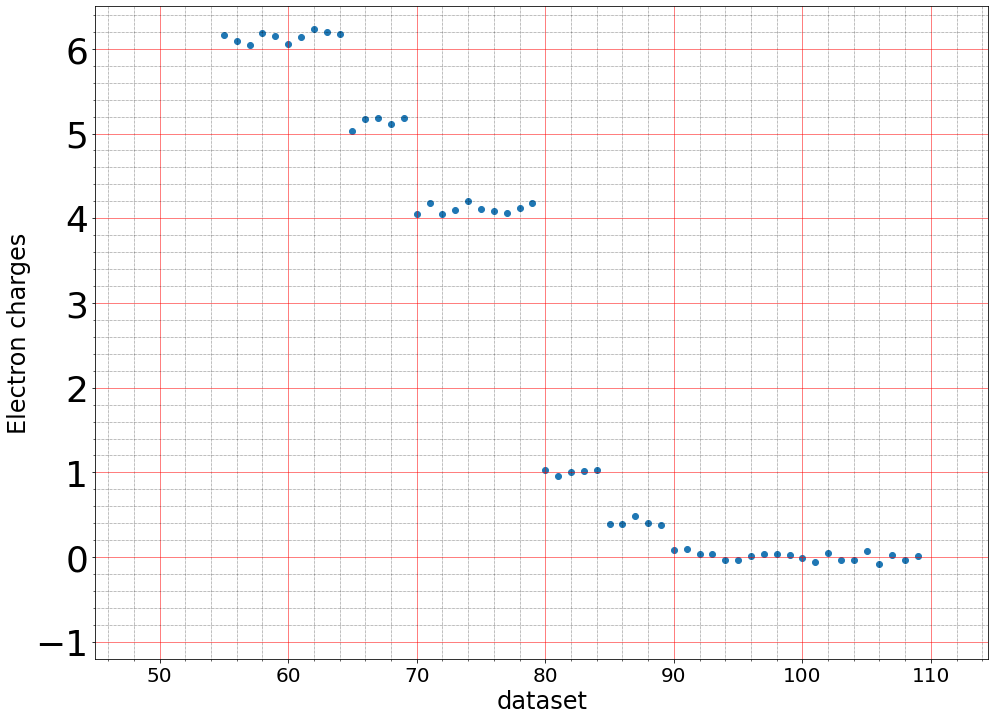

In [7]:
# amps = np.array(amps)
dischargeAmpArr = np.array(dischargeAmps)
_,ax = plt.subplots(figsize=(16,12))
# scale = 326.26

# Perrinf
ax.scatter(range(len(dischargeAmpArr)), -1*dischargeAmpArr/scaleX, label='fit phase')
# ax.scatter(range(len(amps3)), amps3/scale, label='fit fixed-phases')

ax.set(xlabel='dataset', ylabel='Electron charges',ylim=(-1.2,6.5), xlim=(45,None))
ax.grid(axis='y')
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
# ax.legend()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

In [9]:
folder = r'/data/new_trap/20210819/Bead1/Neutrality/200V_X_SPINYZ_58p5kHz_100V_20210820/'
df0,v0 = compare_millicharge_full_analysis_perFile(folder,fileNo=1884,gap=2,ElectrodeRatio=0.74,scaleFactor=scaleX)

100%|██████████| 1884/1884 [00:56<00:00, 33.46it/s]


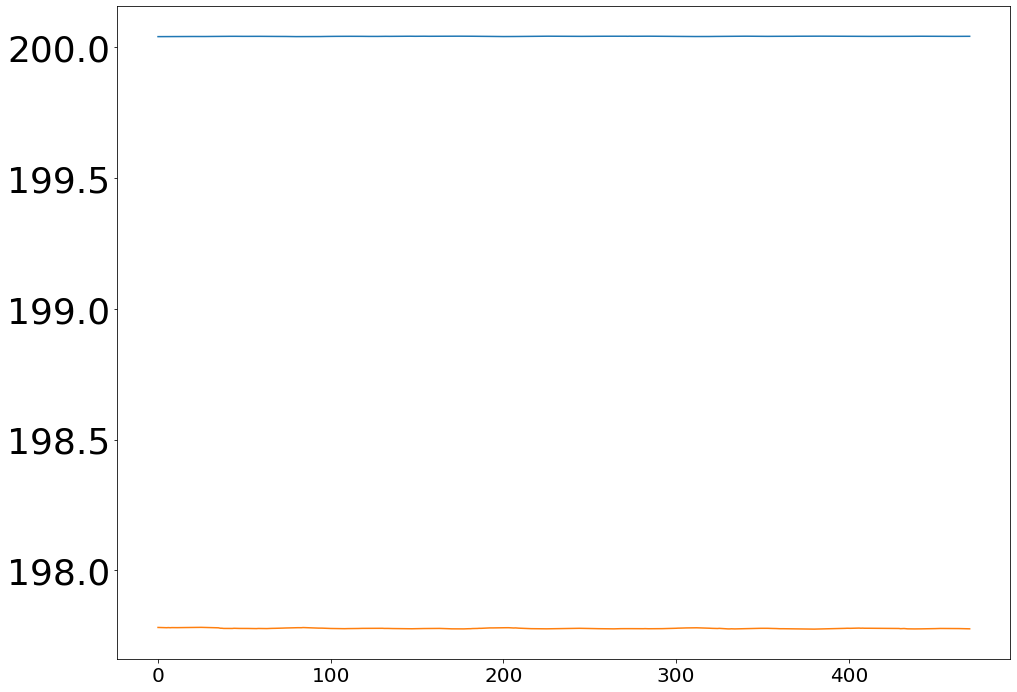

In [10]:
plt.plot(v0[0][0::4])
plt.plot(v0[1][2::4])
plt.show()

F1     -1.460572e-03
F2      8.162885e-03
F3      3.594943e+00
G1     -5.560136e-02
G2      9.685418e-02
G3      1.539783e+00
A       4.579963e-03
A/Um    3.690994e-07
B       8.774283e-02
dtype: float64
F1      2.829946e-04
F2      5.359075e-04
F3      3.948254e+00
G1      1.956436e-04
G2      3.160039e-04
G3      3.448821e+00
A       4.931076e-04
A/Um    3.973956e-08
B       5.072299e-04
dtype: float64
F1       -5.161131
F2       15.231891
F3        0.910515
G1     -284.197117
G2      306.496755
G3        0.446466
A         9.287960
A/Um      9.287960
B       172.984352
dtype: float64


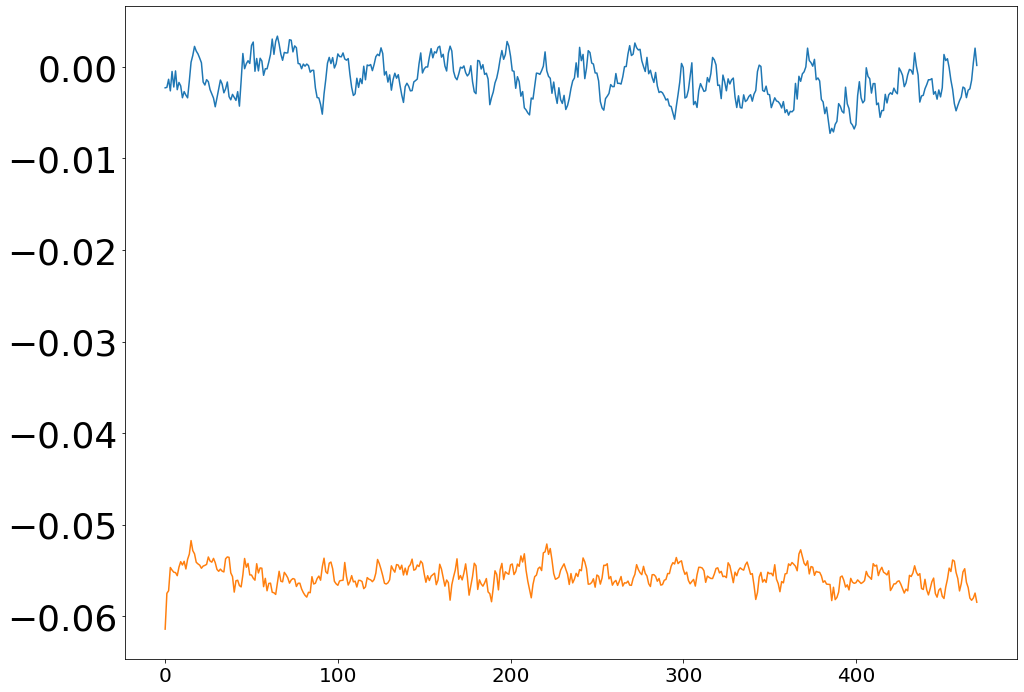

In [11]:
qdf0 = quickAnalyzeDataFrame(df0)

In [12]:
folder = r'/data/new_trap/20210819/Bead1/Neutrality/200V_X_SPINYZ_58p5kHz_100V_20210822/'
           
df1,v1 = compare_millicharge_full_analysis_perFile(folder,fileNo=2220,gap=2,ElectrodeRatio=0.74,scaleFactor=scaleX)

100%|██████████| 2220/2220 [00:26<00:00, 83.37it/s] 


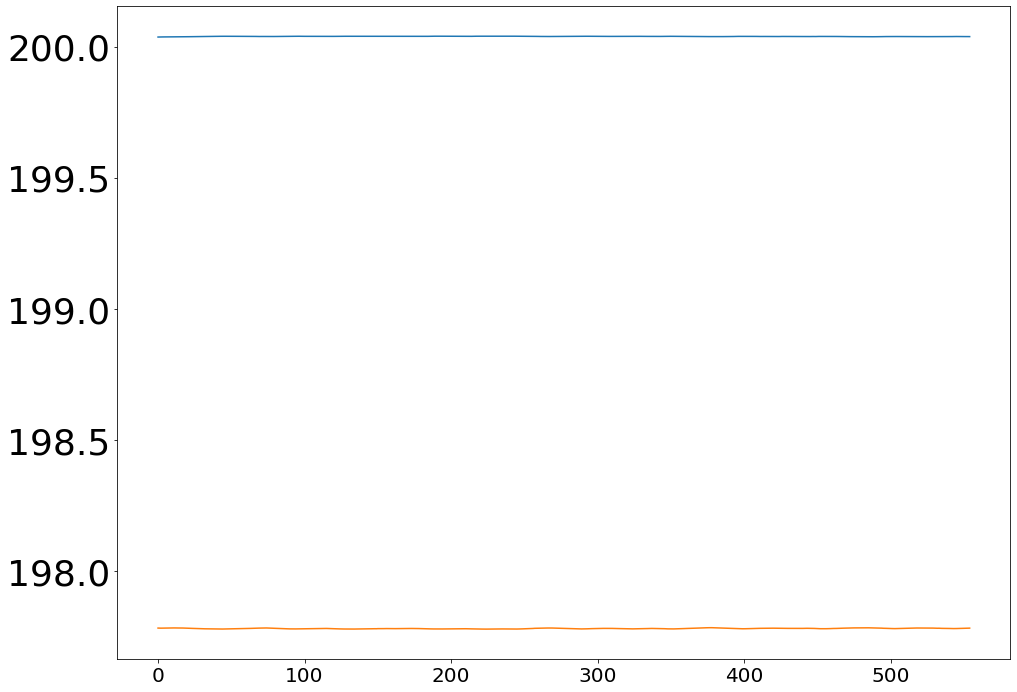

In [13]:
plt.plot(v1[0][0::4])
plt.plot(v1[1][2::4])
plt.show()

F1     -4.462459e-03
F2      1.415576e-02
F3     -1.420542e+00
G1     -6.525846e-02
G2      1.140070e-01
G3     -2.760256e+00
A       6.012804e-03
A/Um    4.845715e-07
B       1.034719e-01
dtype: float64
F1      2.719221e-04
F2      3.191196e-04
F3      3.145610e+00
G1      2.426769e-04
G2      1.667923e-04
G3      2.901196e+00
A       3.466352e-04
A/Um    2.793531e-08
B       3.461784e-04
dtype: float64
F1      -16.410803
F2       44.358798
F3       -0.451595
G1     -268.910854
G2      683.526592
G3       -0.951420
A        17.346203
A/Um     17.346203
B       298.897467
dtype: float64


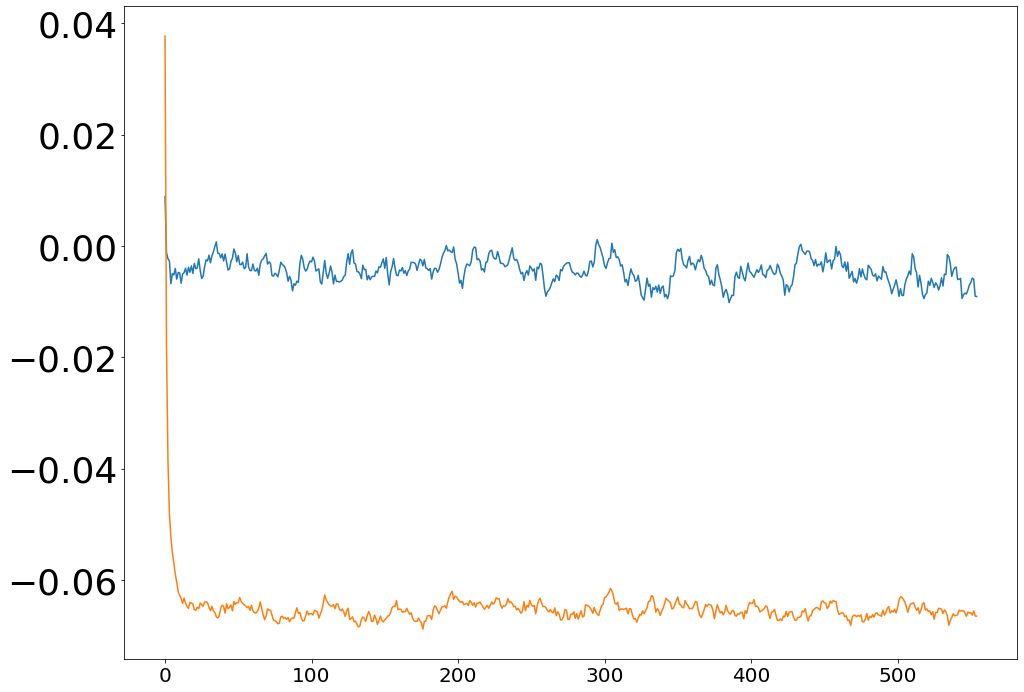

In [14]:
qdf1 = quickAnalyzeDataFrame(df1)

In [16]:
# no gap measurements
folder = r'/data/new_trap/20210819/Bead1/Neutrality/200V_X_SPINYZ_38p25kHz_100V_20210822/'
           
df2,v2 = compare_millicharge_full_analysis_perFile(folder,fileNo=4648,gap=2,ElectrodeRatio=0.74,scaleFactor=scaleX)


100%|██████████| 4648/4648 [00:56<00:00, 82.03it/s]

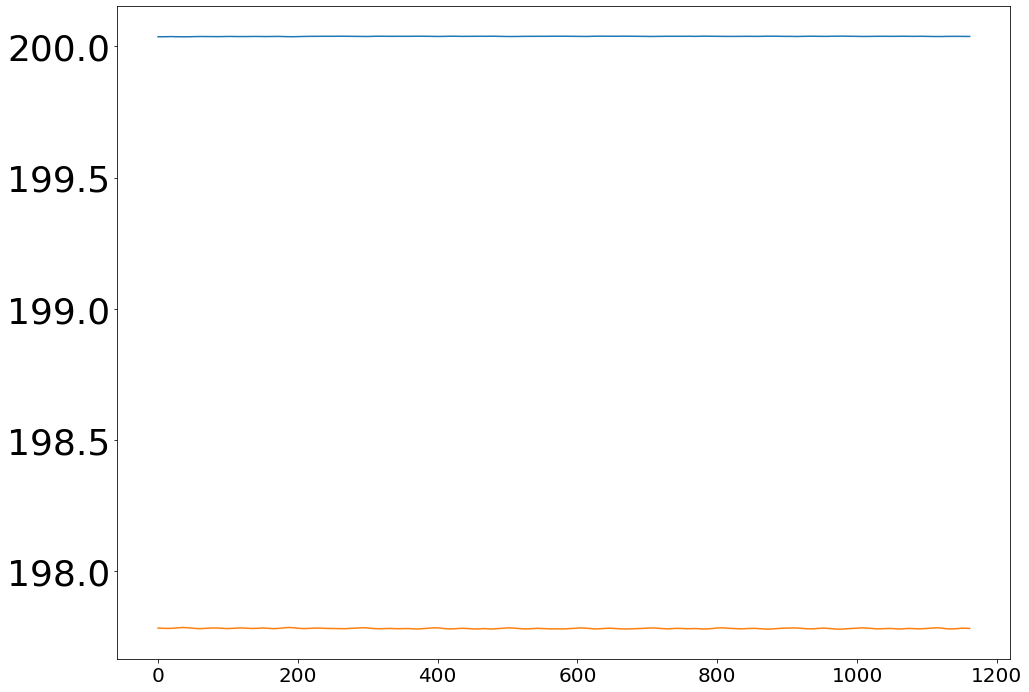

In [17]:
plt.plot(v2[0][0::4])
plt.plot(v2[1][2::4])
plt.show()

F1     -6.823324e-03
F2      1.819191e-02
F3      4.818749e+00
G1     -6.746092e-02
G2      1.172383e-01
G3     -7.128165e-01
A       6.638692e-03
A/Um    5.350148e-07
B       1.060517e-01
dtype: float64
F1      2.222926e-04
F2      2.389521e-04
F3      2.813032e+00
G1      1.499428e-04
G2      1.302051e-04
G3      2.413683e+00
A       2.735592e-04
A/Um    2.204624e-08
B       2.416280e-04
dtype: float64
F1      -30.695234
F2       76.132055
F3        1.713009
G1     -449.910969
G2      900.412594
G3       -0.295323
A        24.267847
A/Um     24.267847
B       438.905111
dtype: float64


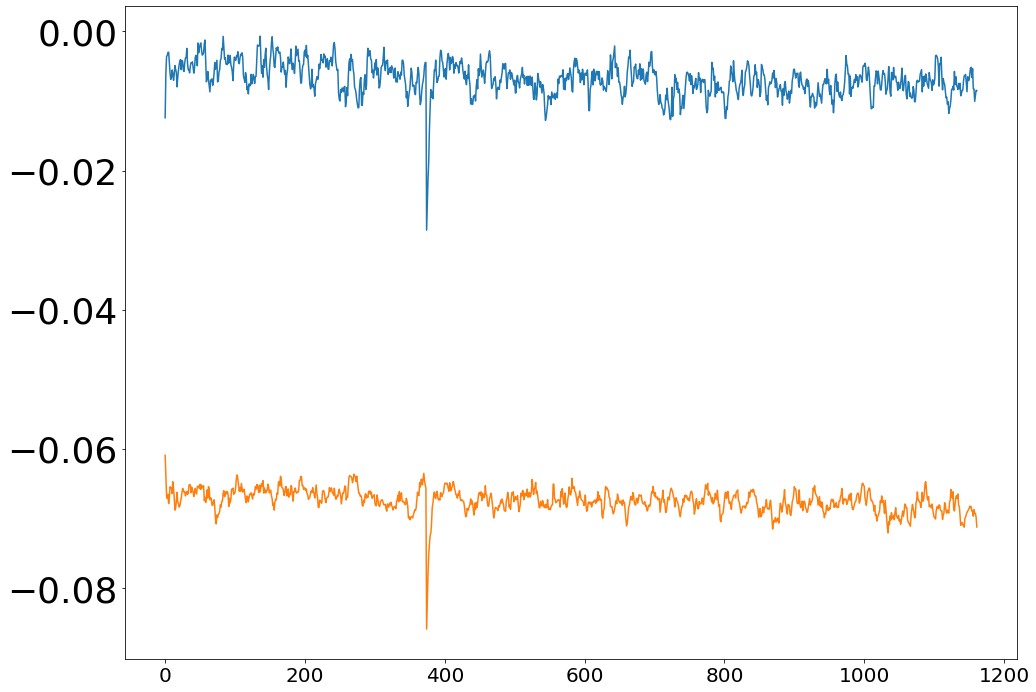

In [18]:
qdf2 = quickAnalyzeDataFrame(df2)

In [19]:
# no gap measurements
folder = r'/data/new_trap/20210819/Bead1/Neutrality/200V_X_noSpin_20210820/'
           
df3,v3 = compare_millicharge_full_analysis_perFile(folder,fileNo=5252,gap=2,ElectrodeRatio=0.74,scaleFactor=scaleX)


100%|██████████| 5252/5252 [00:54<00:00, 96.71it/s]

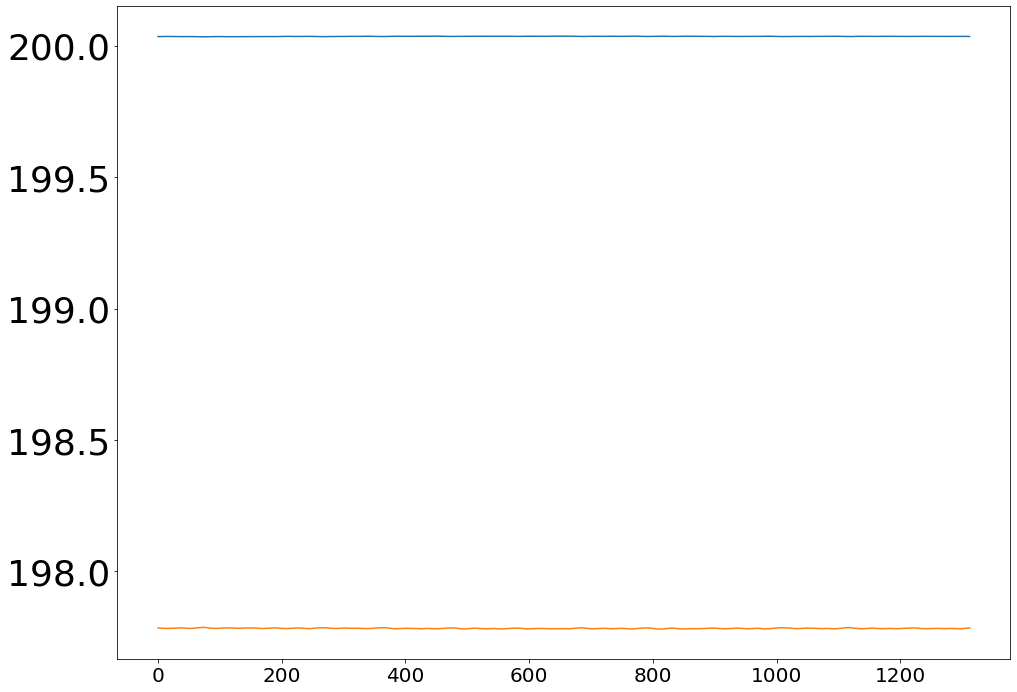

In [20]:
plt.plot(v3[0][0::4])
plt.plot(v3[1][2::4])
plt.show()

F1      -0.036835
F2      -0.046328
F3     -37.686260
G1      -0.069231
G2       0.114872
G3     -26.990136
A       -0.071118
A/Um    -0.000006
B        0.100780
dtype: float64
F1      2.728869e-03
F2      1.918341e-03
F3      2.733525e+01
G1      2.009952e-03
G2      1.956300e-03
G3      1.504514e+01
A       3.090677e-03
A/Um    2.490794e-07
B       3.554179e-03
dtype: float64
F1     -13.498389
F2     -24.150182
F3      -1.378669
G1     -34.443919
G2      58.718992
G3      -1.793943
A      -23.010577
A/Um   -23.010577
B       28.355325
dtype: float64


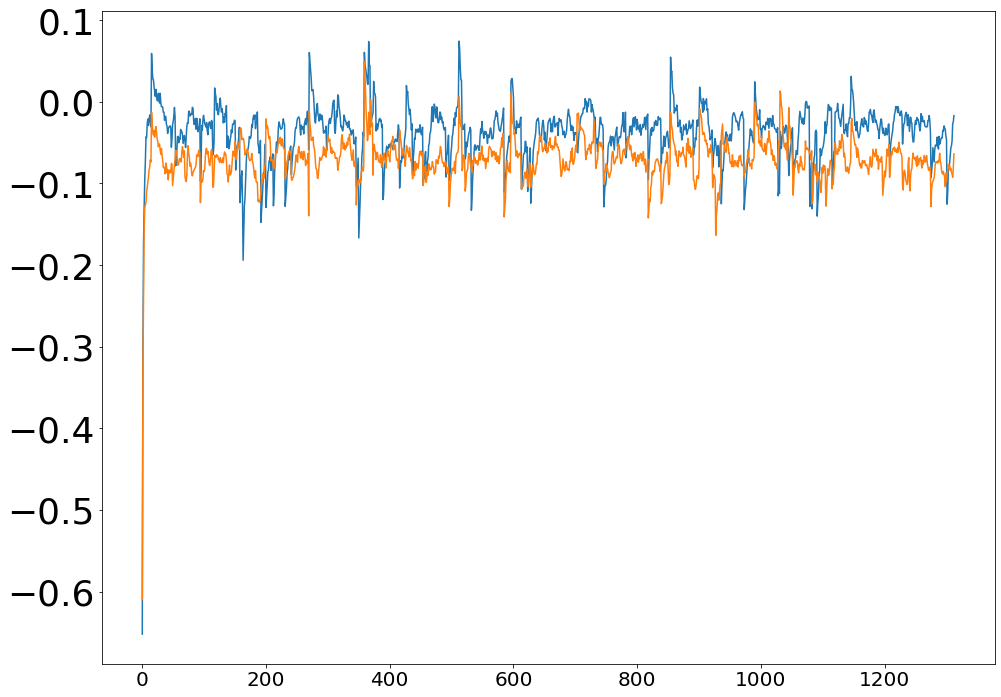

In [21]:
qdf3,v3 = quickAnalyzeDataFrame(df3)

F1      -0.010846
F2      -0.046895
F3     -33.203249
G1      -0.068020
G2       0.114467
G3     -35.196834
A       -0.045549
A/Um    -0.000004
B        0.101392
dtype: float64
F1      8.354034e-04
F2      2.278065e-03
F3      3.327174e+01
G1      1.279385e-03
G2      2.243928e-03
G3      1.837082e+01
A       1.849923e-03
A/Um    1.490863e-07
B       3.634211e-03
dtype: float64
F1     -12.983211
F2     -20.585513
F3      -0.997942
G1     -53.165972
G2      51.012012
G3      -1.915909
A      -24.621901
A/Um   -24.621901
B       27.899260
dtype: float64


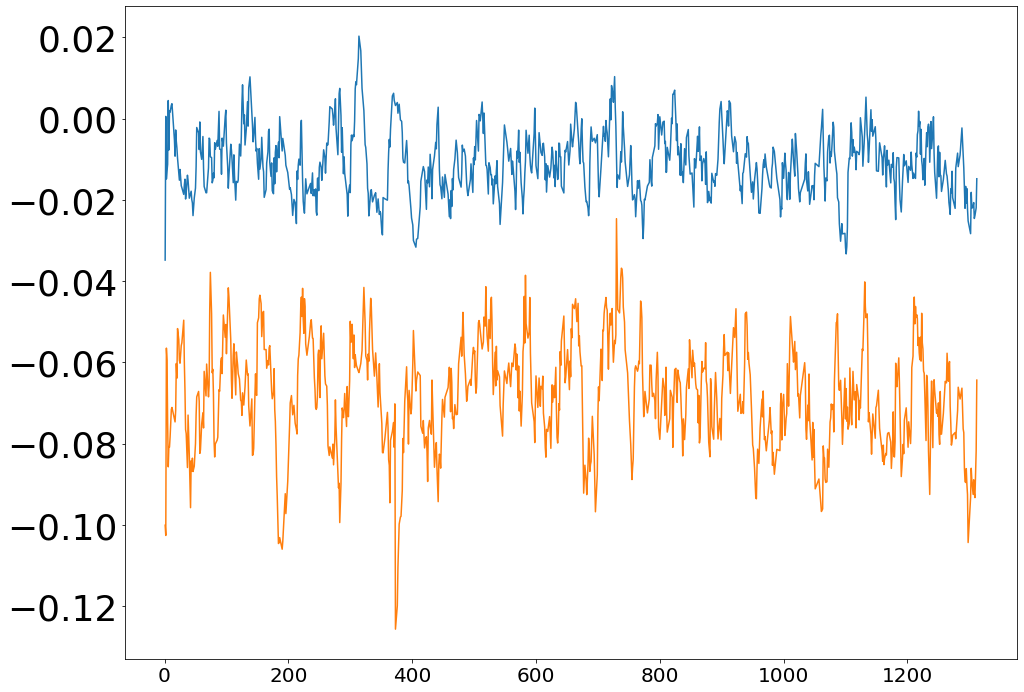

(F1      -0.010846
 F2      -0.046895
 F3     -33.203249
 G1      -0.068020
 G2       0.114467
 G3     -35.196834
 A       -0.045549
 A/Um    -0.000004
 B        0.101392
 dtype: float64,
 F1      8.354034e-04
 F2      2.278065e-03
 F3      3.327174e+01
 G1      1.279385e-03
 G2      2.243928e-03
 G3      1.837082e+01
 A       1.849923e-03
 A/Um    1.490863e-07
 B       3.634211e-03
 dtype: float64)

In [24]:
quickAnalyzeDataFrame(df3[np.abs(df3.F1)<0.05])